# RESTAURANT - Time Series Models

In [37]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import warnings
warnings.simplefilter('ignore')
import multiprocessing
from multiprocessing import Pool
import seaborn as sns
import os
warnings.simplefilter('ignore')

In [38]:
from fbprophet import Prophet

In [39]:
# global vars
# plt.rcParams.keys()
plt.rcParams['grid.linestyle'] ='--'
plt.rcParams['grid.alpha'] = 0.4
plt.rcParams['figure.figsize'] = [7,3]
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.titleweight"] = "bold"

sns.set_palette("PRGn", 10)

In [40]:
%matplotlib inline

In [41]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# IMPORT DATA

In [42]:
path_input = ('../input/')

In [43]:
air_visits = pd.read_csv(os.path.join(path_input,'air_visit_data.csv.gz'))
air_reserve = pd.read_csv(os.path.join(path_input,'air_reserve.csv.gz'))
hpg_reserve = pd.read_csv(os.path.join(path_input,'hpg_reserve.csv.gz'))
air_store = pd.read_csv(os.path.join(path_input,'air_store_info.csv.gz'))
hpg_store = pd.read_csv(os.path.join(path_input,'hpg_store_info.csv.gz'))
holidays = pd.read_csv(os.path.join(path_input,'date_info.csv.gz'))
store_ids = pd.read_csv(os.path.join(path_input,'store_id_relation.csv.gz'))
test = pd.read_csv(os.path.join(path_input,'sample_submission.csv.gz'))

In [44]:
air_visits.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [45]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [46]:
holidays = holidays.rename(columns={'calendar_date':'visit_date'})

In [47]:
tables = [('air_visits',air_visits),
        ('air_reserve',air_reserve),
        ('hpg_reserve',hpg_reserve),
        ('air_store',air_store),
        ('hpg_store',hpg_store),
        ('holidays',holidays),
        ('store_ids',store_ids,),
        ('test',test)]

# BASELINE MODELS  (without training algorithms)

In [48]:
test['visit_date'] = test.id.apply(lambda x: x.split('_')[-1])

test['air_store_id']= test.id.apply(lambda x: '_'.join(x.split('_')[:2]))

# Time series with PROPHET Library

which utilizes a Bayesian based curve fitting method to forecast the time series data. The cool thing about Prophet is that it doesn’t require much prior knowledge or experience of forecasting time series data since it automatically finds seasonal trends beneath the data and offers a set of ‘easy to understand’ parameters. Hence, it allows non statisticians to start using it and get reasonably good results that are often equal or sometimes even better than the ones produced by the experts.

# Prediction for a Restaurant

In [49]:
# We need make prediction for all restaurants
test.air_store_id.nunique()

821

#### Preparing Visit Data for Prophet

Picked air_a55d17bd3f3033cb


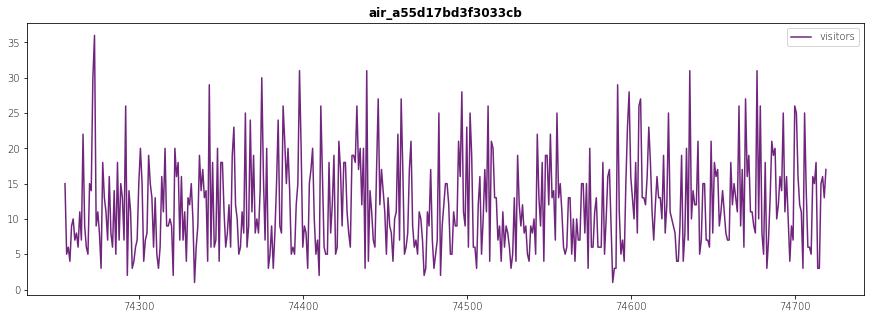

In [67]:
# # picking a random store from test data
random_store = np.random.choice(test.air_store_id.unique())
print("Picked {}".format(random_store))

data = air_visits[air_visits['air_store_id'] == random_store]

data.plot(figsize=(15,5),title=random_store);

In [68]:
## Filling missing dates
# converting visit_date to datetime
data['visit_date'] = pd.to_datetime(data['visit_date'])

# setting date as an index
data = data[['visit_date', 'visitors']].set_index('visit_date')

# creating a new index which covers training time 
date_range = pd.date_range(start=pd.to_datetime('2016-07-01'),
                           end=pd.to_datetime('2017-04-22'))
# how many days to forecast
forecast_days = (pd.to_datetime('2017-05-31')-pd.to_datetime('2017-04-22')).days

# reindexing with full range of days and fillinf missing dates with 0
data = data.reindex(date_range).fillna(0).reset_index()

# converting columns names for prophet
data.columns = ['ds', 'y']

In [69]:
data.head()

,ds,y
0,2016-07-01,18.0
1,2016-07-02,26.0
2,2016-07-03,17.0
3,2016-07-04,20.0
4,2016-07-05,12.0


#### Holidays

In [70]:
holidays.head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [71]:
## Rearrange holidays to fit prophet format
holidays = holidays.rename(columns={'calendar_date':'visit_date'})

df_holidays = holidays[['visit_date','holiday_flg']]

# converting columns names for prophet
df_holidays.columns = ['ds', 'holiday']

# picking only holidays
df_holidays = df_holidays[df_holidays['holiday'] == 1]

# converting flags to 'holiday'
df_holidays['holiday'] = 'holiday'

In [72]:
%%time

m = Prophet(holidays=df_holidays,
            yearly_seasonality=False,   # inter year seasonilty (monthly)
            weekly_seasonality=True,   # inter week seasonality (daily)
            daily_seasonality=False,   # inter dat seasonality (hourly)
    
           )
m.fit(data)
future = m.make_future_dataframe(forecast_days)
forecast = m.predict(future)

CPU times: user 2.14 s, sys: 15.5 ms, total: 2.16 s
Wall time: 2.16 s


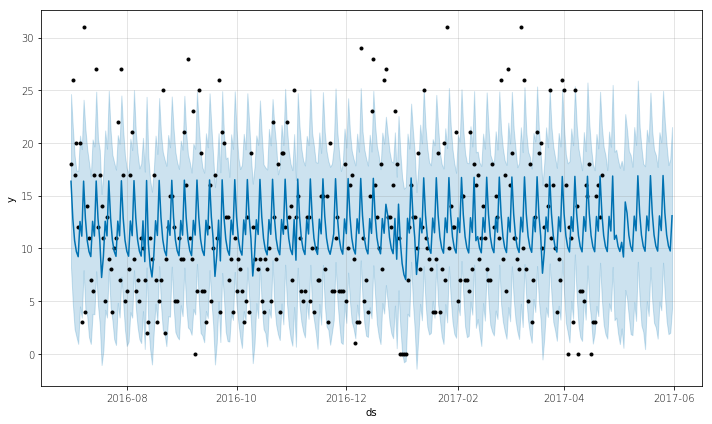

In [73]:
# insample prediction and forecast for 39 days
fig1 = m.plot(forecast)

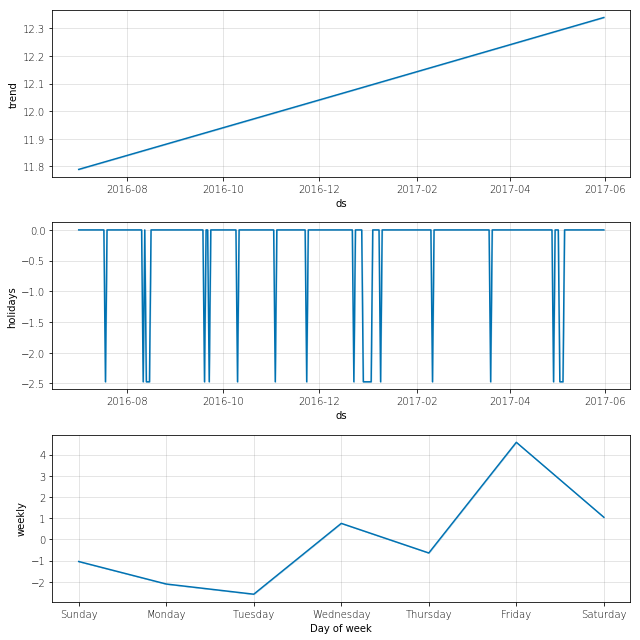

In [74]:
# components 
fig = m.plot_components(forecast)

In [27]:
print('training models for all restaurants : {} hours'.format(round(2*800/60/60,2))) 

training models for all restaurants : 0.44 hours


## Model with all data

Ingridients:
- DataFrame.apply : Apply a function along an axis of the DataFrame. Objects passed to the function are Series objects whose index is either the DataFrame’s index (axis=0) or the DataFrame’s columns (axis=1). 
- multiprocessing library

## Prepare data

In [28]:
# convert visit_date to date_time
air_visits.visit_date = pd.to_datetime(air_visits.visit_date)

# creating train and test date ranges
train_range = pd.date_range(start=pd.to_datetime('2016-07-01'),
                           end=pd.to_datetime('2017-04-22'))

forecast_range = pd.date_range(start=pd.to_datetime('2017-04-23'),
                           end=pd.to_datetime('2017-05-31'))

forecast_days = len(forecast_range)

# create a dataframe with null values
train = pd.DataFrame(
    index=train_range, columns=air_visits.air_store_id.unique())

# unstack columns to fit air_visit format
train = train.unstack().reset_index()

# rename columns
train.columns = ['air_store_id', 'visit_date', 0]

# merge with air_visit table
train = train.merge(air_visits, on=['air_store_id', 'visit_date'], how='left')[
    ['air_store_id', 'visit_date', 'visitors']]

# fill null values
train = train.fillna(0)

# make use of pandas apply method
train = train.set_index(['air_store_id', 'visit_date']).unstack()

In [29]:
## Rearrange holidays to fit prophet format
holidays = holidays.rename(columns={'calendar_date':'visit_date'})

df_holidays = holidays[['visit_date','holiday_flg']]

# converting columns names for prophet
df_holidays.columns = ['ds', 'holiday']

# picking only holidays
df_holidays = df_holidays[df_holidays['holiday'] == 1]

# converting flags to 'holiday'
df_holidays['holiday'] = 'holiday'

In [30]:
train.head()

visitors                                              \
visit_date           2016-07-01 2016-07-02 2016-07-03 2016-07-04 2016-07-05   
air_store_id                                                                  
air_00a91d42b08b08d9       35.0        9.0        0.0       20.0       25.0   
air_0164b9927d20bcc3        0.0        0.0        0.0        0.0        0.0   
air_0241aa3964b7f861       10.0       13.0       20.0        4.0        7.0   
air_0328696196e46f18        0.0        0.0       11.0        4.0        6.0   
air_034a3d5b40d5b1b1       19.0       23.0        5.0       13.0        0.0   

                                                                             \
visit_date           2016-07-06 2016-07-07 2016-07-08 2016-07-09 2016-07-10   
air_store_id                                                                  
air_00a91d42b08b08d9       29.0       34.0       42.0       11.0        0.0   
air_0164b9927d20bcc3        0.0        0.0        0.0        0.0        0.0   
air_0241aa3964b7f861       10.0        1.0        2.0        7.0        3.0   
air_0328696196e46f18        4.0        8.0        8.0       12.0        4.0   
air_034a3d5b40d5b1b1       10.0        3.0       23.0       12.0       13.0   

                        ...                                                  \
visit_date              ...     2017-04-13 2017-04-14 2017-04-15 2017-04-16   
air_store_id            ...                                                   
air_00a91d42b08b08d9    ...           34.0       39.0        0.0        0.0   
air_0164b9927d20bcc3    ...           13.0        7.0        1.0        0.0   
air_0241aa3964b7f861    ...            0.0        4.0       15.0       10.0   
air_0328696196e46f18    ...            0.0        9.0        4.0        3.0   
air_034a3d5b40d5b1b1    ...           22.0       18.0       31.0       39.0   

                                                                             \
visit_date           2017-04-17 2017-04-18 2017-04-19 2017-04-20 2017-04-21   
air_store_id                                                                  
air_00a91d42b08b08d9       19.0       35.0       17.0       38.0       55.0   
air_0164b9927d20bcc3        2.0        1.0        8.0        1.0       26.0   
air_0241aa3964b7f861       12.0       19.0        8.0        0.0        3.0   
air_0328696196e46f18        3.0        0.0       24.0        0.0       19.0   
air_034a3d5b40d5b1b1       25.0       20.0       31.0       12.0       37.0   

                                 
visit_date           2017-04-22  
air_store_id                     
air_00a91d42b08b08d9       18.0  
air_0164b9927d20bcc3        6.0  
air_0241aa3964b7f861       13.0  
air_0328696196e46f18        8.0  
air_034a3d5b40d5b1b1       35.0  

[5 rows x 296 columns]

In [31]:
def forecast_prophet(X):
    # preparing data for prophet format
    data = X.reset_index()
    store_id = data.columns[2]
    data = data.iloc[:,1:]
    data.columns = ['ds', 'y']
    # prediction
    m = Prophet(holidays=df_holidays,
            yearly_seasonality=False,
            weekly_seasonality=True, 
            daily_seasonality=False,)
    m.fit(data)
    future = m.make_future_dataframe(forecast_days)
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat']]
    forecast.columns = ['id', 'visitors']

    return forecast.visitors[-forecast_days:]

cores = multiprocessing.cpu_count()
# cores =2 

def parallelize_dataframe(df, func):
    # split data 
    df_split = np.array_split(df, cores)
    # process pool object
    pool = Pool(cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df
    
def apply_prophet(df):
    forecast =  df.apply(lambda x: forecast_prophet(x),axis=1)
    return forecast

In [32]:
%%time
# # This is used for suppressing prophet info messages.
# logging.getLogger('fbprophet.forecaster').propagate = False

df_forecast_prophet = parallelize_dataframe(train, apply_prophet)

CPU times: user 330 ms, sys: 398 ms, total: 728 ms
Wall time: 1min 36s


In [33]:
## Formating Dataframe 

# renaming columns
df_forecast_prophet.columns = [e.strftime('%Y-%m-%d') for e in forecast_range]

# stacking columns
df_forecast_prophet = df_forecast_prophet.stack().reset_index()

# creating id column
df_forecast_prophet['id'] = df_forecast_prophet.apply(lambda x:'%s_%s'%(x['air_store_id'], x['level_1']),axis=1)

# rename visitors columns
df_forecast_prophet = df_forecast_prophet.rename(columns={0:'visitors'})

In [34]:
## Not all the restaurants in train data exist in test data

# reindex forecast table
df_forecast_prophet = df_forecast_prophet[['id','visitors']].set_index('id')
# create a submission file
test_prophet = test.set_index('id').copy()
# update values
test_prophet.update(df_forecast_prophet)

# submission
# test_prophet.reset_index()[['id','visitors']].to_csv('./submissions/parallel_prophet_2012.csv', index=False)

# Prophet Submission
private:0.600  public:0.542